# Self-Driving Car Engineer Nanodegree


## Project: **Car Tracking** 
---

## Ideas for Lane Detection Pipeline

- Gather the Dataset
- Decide on which features to use
- Create Classifier and Train it
- Use sliding window technique to search for vehicles in a frame
- Tune to reduce false positives and improve tracking

## Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.utils import shuffle
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
%matplotlib inline

#Enable this variable to enable visualization 
display = True #False
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

/home/korivi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/korivi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Reading the Data Set

In [4]:
"""
Read all the data sets for feature extraction
"""

cars = []
notcars = []
#images = glob.glob('./small_data/*/*/*.jpeg')
images = glob.glob('./big_data/*/*/*.png')
for image in images:
    #if 'image' in image or 'extra' in image:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars),len(notcars))

8792 8968


## Feature extraction from Images

In [6]:
#TODO combines both features- normalize and stuff to check what to do
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Function to return HOG features and visualization
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    """
    function to compute binned color features  
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Function to compute color histogram features 
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Have this function call bin_spatial() and color_hist()
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):  
    """
    Function to extract and combine all features requested in an image
    """
    #1) Empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Function to extract features from set of images and return the combined feature list
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        img_features = single_img_features(image, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(img_features)
    
    return features
    


## Classifier

In [7]:
"""
#Constants used through out the process
"""
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()

In [5]:
"""
Combines features, split data as test and train. Train the model and save the model to a
pickled file for future use
"""
ts=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

#Create an array of features
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

X_train, y_train = shuffle(X_train, y_train)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Check the training time for the SVC
t=time.time()

# Use a linear SVC  and train the model
svc = LinearSVC()
svc.fit(X_train, y_train)

pickle_parameters = {"svc":svc,"X_scaler":X_scaler,"color_space":color_space, "orient":orient,"pix_per_cell":pix_per_cell,
               "cell_per_block":cell_per_block,"hog_channel":hog_channel,"spatial_size":spatial_size,
               "hist_bins":hist_bins,"spatial_feat":spatial_feat,"hist_feat":hist_feat, "hog_feat":hog_feat,
               "y_start_stop":y_start_stop
              }

pickle.dump( pickle_parameters, open( "retrain_all_params.p", "wb" ) )

#Reshuffle test data
X_test, y_test = shuffle(X_test, y_test)


t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print(round(t2-ts, 2), 'create features and train')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
print(round(t-t2, 5), 'Test time...')

/home/korivi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
17.29 Seconds to train SVC...
239.22 create features and train
Test Accuracy of SVC =  0.9885
0.02988 Test time...


### code to check params from pickled file

In [6]:
pickle_parameters_n = pickle.load( open( "retrain_all_params.p", "rb" ) ) 
svc2 = pickle_parameters_n["svc"]
t2=time.time()
print('Test Accuracy of SVC = ', round(svc2.score(X_test, y_test), 4))
t=time.time()
print(round(t-t2, 5), 'Test time...')

Test Accuracy of SVC =  0.9885
0.03789 Test time...


### Functions to Track Cars in an Image

In [72]:
# See that features here are same as features used in training
def convert_color(img, conv='RGB2YCrCb'):
    """
    Function to convert to different colorspace and return the converted image
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins,hog_channel):
    """
    The function takes in the model, image and other parametrs and returns the image with boxes on cars found.
    """
    car_boxes = []
    once = True
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    #channel to extract hog features from
    if hog_channel == "ALL":
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch2 = ctrans_tosearch[:,:,hog_channel]  # Choosing hog_channel = 1 if not all 
    

    # Define blocks and steps as above #Below 2 moved inside to accomodate more types of cells in image
    nxblocks = (ch2.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch2.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    pix_per_cell = pix_per_cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step +1 #id +1 as the loop was not reaching end of frames
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print('vals::',window,pix_per_cell,nblocks_per_window,cells_per_step,nxsteps,nysteps,nxblocks,nyblocks)

    # Compute individual channel HOG features for the entire image
    if hog_channel == "ALL":
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,  vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,  vis=False, feature_vec=False)
    
    # Scan through the image in steps defined looking for cars
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch

            if(hog_channel == "ALL"):
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat2))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #check for prediction of the box
            test_prediction = svc.predict(test_features)
            #If a car is predicted
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0) ,5) 
                car_boxes.append([[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]])

    return draw_img,car_boxes


## Build Heatmap and remove false positives

In [85]:
def add_heat(heatmap, bbox_list):
    """
    Function takes in a single channel image, boxes list, builts heat map adding 1 to all pixels in box
    returns the image with heat info
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    """
    Apply threshold to heat image to get rid of false positives
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    """
    Function compares the boxes between current and previosu frames and places them in current frame only
    if they existed in previsous frame and are atleast 20 pixels apart
    """
    
    global o_boxes #old boxes
    n_boxes = [] # new boxes
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #print('bbbox:,', bbox)
        # Draw the box on the image
        n_boxes.append(bbox)
        cv2.rectangle(img,bbox[0], bbox[1], (255,0,0), 6)
        #print(bbox[0],bbox[1])
        #font = cv2.FONT_HERSHEY_SIMPLEX
        #cv2.putText(img,'{},{},{},{}'.format(bbox[0][0],bbox[0][1],bbox[1][0],bbox[1][1]),
        #            (10,100+car_number*100), font, 1,(255,0,0),2,cv2.LINE_AA)
    # Return the image
    
    #Draw all boxes
    n_boxes = np.array(n_boxes)
    if(o_boxes == None):
        for box in n_boxes:
            cv2.rectangle(img, (box[0][0],box[0][1]),(box[1][0],box[1][1]), (0,0,255), 6)
            #print('box::', box)
    else:
        for nb in n_boxes:
            for ob in o_boxes:
                if np.max(ob -nb) < 20: # old square and new square are 20pixels apart
                    cv2.rectangle(img,(nb[0][0],nb[0][1]), (nb[1][0],nb[1][1]), (0,0,255), 6)  
    o_boxes= n_boxes
    return img


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [75]:
import os
os.listdir("test_images/")

['test3.jpg',
 'test2.jpg',
 'test4.jpg',
 'test5.jpg',
 '.DS_Store',
 'test6.jpg',
 'test1.jpg']

## Test on Single Image - Pipeline


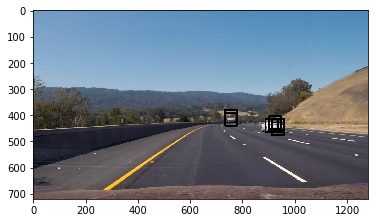

7


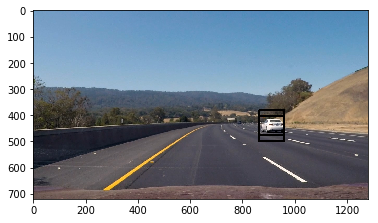

2


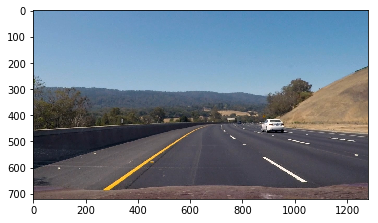

0


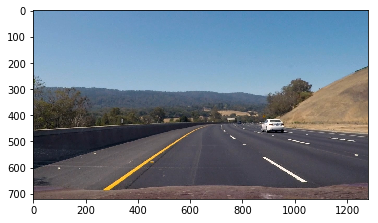

0
9


In [86]:
# code
#Different y ranges for different scales
yss = [[380,500],[380,550],[380,550],[380,720]]
scl = [0.75,1.5,2,3]

#which trained parameters to load
if(hog_channel == "ALL"):
    #filename = './large_data_alltrain.joblib.pkl'
    pickle_parameters_n = pickle.load( open( "retrain_all_params.p", "rb" ) ) 
    svc2 = pickle_parameters_n["svc"]
else:
    #filename = './large_data_train.joblib.pkl'
    #svc2 = joblib.load(filename)
    pickle_parameters_n = pickle.load( open( "model_trained_hg_c_1.p", "rb" ) ) 
    svc2 = pickle_parameters_n["svc"]

X_scaler = pickle_parameters_n["X_scaler"]
#read in an image
im = mpimg.imread("./test_images/test3.jpg").astype(np.float32)/255
car_full_boxes=[]
for i in range(len(scl)) :
    scale = scl[i]
    ystart =yss[i][0]
    ystop =yss[i][1]
    #final image wih cars
    out_img, car_boxes = find_cars(im, ystart, ystop, scale, svc2, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel)
    car_full_boxes.extend(car_boxes)
    plt.imshow(out_img)
    plt.show()
    print(len(car_boxes))
print(len(car_full_boxes))

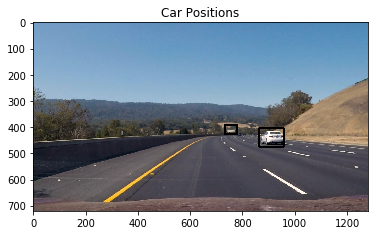

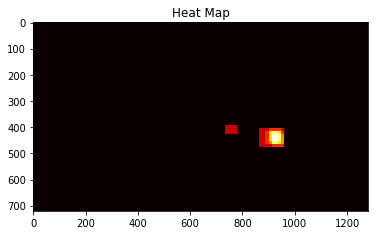

In [88]:
#COmbine all the detections to one per car using the heat functions

o_boxes = None
# Add heat to each box in box list
heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
heat = add_heat(heat,car_full_boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(im), labels)


fig = plt.figure()
#plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.show()
#plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Test on Videos


In [80]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


### Pipeline to process the images from video

In [87]:
yss = [[380,500],[380,550],[380,550],[380,720]]
scl = [0.75,1.5,2,3]
def process_image(image):
    """
    Pipeline for processing of the image from Video 
    """
    global d_labels, f_count
    #process only one in 3 frames to increase speed
    if f_count%3 == 0:
        im = image.astype(np.float32) #/255
        #out_img, car_boxes = find_cars(im, ystart, ystop, scale, svc2, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel)
        car_full_boxes=[]
        for i in range(len(scl)) :
            scale = scl[i]
            ystart =yss[i][0]
            ystop =yss[i][1]
            out_img, car_boxes = find_cars(im, ystart, ystop, scale, svc2, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel)
            car_full_boxes.extend(car_boxes)
        #Circle the cars on centroid
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat,car_full_boxes)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,3)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        d_labels = labels
    
    f_count += 1
    draw_img = draw_labeled_bboxes(np.copy(image), d_labels)
    return draw_img

Let's try the one with the solid white lane on the right first ...

In [89]:
#Video Processing
#clip1 = VideoFileClip("test_video.mp4")#.subclip(38,43)
#white_output = 'm_out_test_video.mp4'

f_count = 0
d_labels = None

o_boxes = None

clip1 = VideoFileClip("project_video.mp4").subclip(38,43)
white_output = 'm_out_project_video.mp4'

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video m_out_project_video.mp4
[MoviePy] Writing video m_out_project_video.mp4


 99%|█████████▉| 125/126 [00:40<00:00,  3.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: m_out_project_video.mp4 

CPU times: user 49.6 s, sys: 192 ms, total: 49.8 s
Wall time: 42.5 s


In [ ]:
#Challenge Video Clip
white_output = 'out_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Now for the one with the solid yellow lane on the left. This one's more tricky!